In [ ]:
import os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("✅ Kaggle API key configured successfully!")


In [ ]:
!kaggle competitions list


In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p ./
!unzip -o "*.zip"


In [ ]:
import os
print(os.listdir("."))


In [2]:
import pandas as pd
df = pd.read_csv("/Users/shyaam/Documents/IRL/train.csv")
df["toxic_label"] = (df["toxic"] > 0).astype(int)
df["comment_length"] = df["comment_text"].apply(len)
df_sorted = df.sort_values(by="comment_length")
toxic_comments = df_sorted[df_sorted["toxic_label"] == 1].iloc[2500:3500]
non_toxic_comments = df_sorted[df_sorted["toxic_label"] == 0].iloc[2500:3500]
final_df = pd.concat([toxic_comments, non_toxic_comments])
final_df = final_df.rename(columns={"comment_text": "Prompt"})
final_df["Target Output"] = final_df["Prompt"]
final_df = final_df[["Prompt", "Target Output", "toxic_label"]]
final_df.to_csv("Jigsaw-2000.csv", index=False)
print("✅ Processing completed! 'Jigsaw-2000.csv' is saved.")


✅ Processing completed! 'Jigsaw-2000.csv' is saved.


In [3]:
df = pd.read_csv("Jigsaw-2000.csv")
print(df.head())
print(df["toxic_label"].value_counts())


                                            Prompt  \
0  gay \n\nhave a look at young buck now ye faggit   
1    Do not revert my requests you son of a bitch!   
2  Dick \n\nTheir principal is known to be a dick.   
3  .\n\nTough fucking shit, buddy.  Request denied   
4    Welcome to the Nazi website.  Where's Hitler?   

                                     Target Output  toxic_label  
0  gay \n\nhave a look at young buck now ye faggit            1  
1    Do not revert my requests you son of a bitch!            1  
2  Dick \n\nTheir principal is known to be a dick.            1  
3  .\n\nTough fucking shit, buddy.  Request denied            1  
4    Welcome to the Nazi website.  Where's Hitler?            1  
toxic_label
1    1000
0    1000
Name: count, dtype: int64


In [4]:
from datasets import Dataset
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
def tokenize_function(examples):
    return tokenizer(examples["Prompt"], padding="max_length", truncation=True)
dataset = Dataset.from_pandas(df)
tokenized_dataset = dataset.map(tokenize_function, batched=True)
train_test_split = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]
print("✅ Dataset tokenized and split for training.")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ Dataset tokenized and split for training.


In [5]:
train_dataset = train_dataset.rename_columns({"toxic_label": "labels"})
test_dataset = test_dataset.rename_columns({"toxic_label": "labels"})


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,  
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    disable_tqdm=False,  
    report_to="none",
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)
print("✅ Trainer initialized.")


In [26]:
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"



In [27]:
from transformers import logging
logging.set_verbosity_info()


In [ ]:
from tqdm import tqdm
import time
total_steps = len(trainer.get_train_dataloader()) * training_args.num_train_epochs
progress_bar = tqdm(total=total_steps, desc="Training Progress")
start_time = time.time()
for epoch in range(training_args.num_train_epochs):
    trainer.train()
    progress_bar.update(len(trainer.get_train_dataloader()))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"⏳ Training completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes). ✅")


In [ ]:
trainer.evaluate()

In [ ]:
model.save_pretrained("roberta-toxic-classifier")
tokenizer.save_pretrained("roberta-toxic-classifier")
print("✅ Model saved as 'roberta-toxic-classifier'")


In [11]:
print(train_dataset["Target Output"][:5])


['Thats ok I have plenty more', 'I find this article Humerus', 'UTfuckin retard go get a fucking life u bitchC', 'to be unblocked, its just', "Sorry, I don't believe that"]


In [ ]:
model.save_pretrained("roberta-toxic-classifier")
tokenizer.save_pretrained("roberta-toxic-classifier")
print("✅ Model saved as 'roberta-toxic-classifier'")


In [15]:
sample_text = train_dataset["Target Output"][0]  
tokenized = tokenizer(sample_text, return_tensors="pt")

print(f"Sample text: {sample_text}")
print(f"Token IDs: {tokenized['input_ids']}")
print(f"Max Token ID in Sample: {tokenized['input_ids'].max().item()}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")


Sample text: Thats ok I have plenty more
Token IDs: tensor([[2773,   84, 8718,  309,  452, 9828,  625]])
Max Token ID in Sample: 9828
Tokenizer vocab size: 50254


In [16]:
reward_tokenizer = AutoTokenizer.from_pretrained("/Users/shyaam/Documents/IRL/roberta-toxic-classifier")
if reward_tokenizer.vocab_size != tokenizer.vocab_size:
    print(f"⚠️ Mismatch: Reward Model Tokenizer Vocab = {reward_tokenizer.vocab_size}, Pythia Tokenizer Vocab = {tokenizer.vocab_size}")


⚠️ Mismatch: Reward Model Tokenizer Vocab = 50265, Pythia Tokenizer Vocab = 50254


In [20]:
from tqdm import tqdm 

In [39]:
from trl import PPOTrainer, PPOConfig, set_seed
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer
from trl.models import AutoModelForCausalLMWithValueHead
import torch

config = PPOConfig(
    learning_rate=1e-5,
    batch_size=16,  
    mini_batch_size=4,
    gradient_accumulation_steps=4,
)

pythia_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
pythia_tokenizer.pad_token = pythia_tokenizer.eos_token  # Ensure correct padding ???
roberta_tokenizer = AutoTokenizer.from_pretrained("/Users/shyaam/Documents/IRL/roberta-toxic-classifier")
roberta_tokenizer.pad_token = roberta_tokenizer.eos_token  # Ensure correct padding???
model = AutoModelForCausalLMWithValueHead.from_pretrained("EleutherAI/pythia-70m")
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained("EleutherAI/pythia-70m")
reward_model = AutoModelForSequenceClassification.from_pretrained("/Users/shyaam/Documents/IRL/roberta-toxic-classifier")
if hasattr(model.pretrained_model, "resize_token_embeddings"):
    model.pretrained_model.resize_token_embeddings(len(pythia_tokenizer))

def reward_fn(example):
    inputs = roberta_tokenizer(example["Target Output"], padding=True, truncation=True, return_tensors="pt").to(reward_model.device)
    vocab_size = roberta_tokenizer.vocab_size
    inputs["input_ids"] = torch.clamp(inputs["input_ids"], max=vocab_size - 1)
    with torch.no_grad():
        outputs = reward_model(**inputs)    
    logits = outputs.logits
    reward = torch.sigmoid(logits[:, 0]).item()
    return {"reward": reward} 
train_dataset = train_dataset.map(reward_fn)

trainer = PPOTrainer(
    config=config,
    model=model,  
    ref_model=ref_model,  
    tokenizer=pythia_tokenizer, 
    dataset=train_dataset, 
)

print("✅ PPO Trainer initialized for RLHF fine-tuning with your trained reward model!")

for epoch in range(3): 
    total_rewards = 0  
    total_loss = 0   
    for batch in tqdm(train_dataset, desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        batch_queries = []
        batch_responses = []
        batch_rewards = []
        max_length = 512  
        inputs = pythia_tokenizer(batch["Prompt"], return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        query_tensors = inputs.input_ids.to(model.pretrained_model.device)
        attention_mask = inputs.attention_mask.to(model.pretrained_model.device)

        response_tensors = model.generate(query_tensors, attention_mask=attention_mask, max_new_tokens=50, pad_token_id=pythia_tokenizer.eos_token_id)
        response_texts = pythia_tokenizer.batch_decode(response_tensors, skip_special_tokens=True)
        rewards = [reward_fn({"Target Output": text})["reward"] for text in response_texts]
        batch_queries.extend(query_tensors)
        batch_responses.extend(response_tensors)
        batch_rewards.extend(rewards)
        if len(batch_queries) >= config.batch_size:

            batch_rewards_tensor = [torch.tensor(reward, device=model.pretrained_model.device)
                                    for reward in batch_rewards]
            trainer.step(batch_queries, batch_responses, batch_rewards_tensor)
            batch_queries.clear()
            batch_responses.clear()
            batch_rewards.clear()
    tqdm.write(f"Epoch {epoch + 1} - Total Rewards: {total_rewards}")

print("✅ Training completed!")





Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

✅ PPO Trainer initialized for RLHF fine-tuning with your trained reward model!


Epoch 1 - Total Rewards: 0


Epoch 2 - Total Rewards: 0


Epoch 3 - Total Rewards: 0
✅ Training completed!


In [40]:
save_directory = "//Users/shyaam/Documents/IRL/fine_tuned_models"
model.save_pretrained(save_directory)
ref_model.save_pretrained(save_directory)
reward_model.save_pretrained(save_directory)
pythia_tokenizer.save_pretrained(save_directory)
roberta_tokenizer.save_pretrained(save_directory)
print(f"Models and tokenizers have been saved to {save_directory}")


Models and tokenizers have been saved to //Users/shyaam/Documents/IRL/fine_tuned_models


In [42]:
test_dataset

Dataset({
    features: ['Prompt', 'Target Output', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 400
})

If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at /Users/shyaam/Documents/IRL/fine_tuned_models and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.53
F1 Score: 0.0


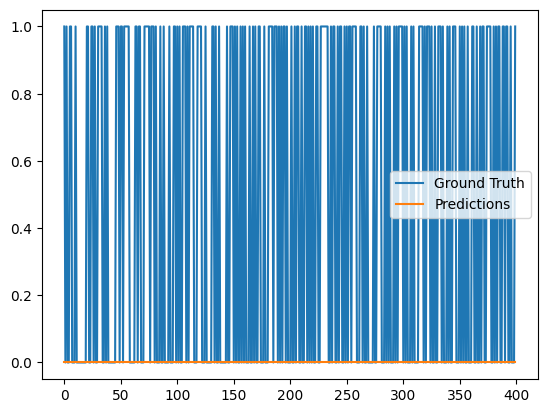

In [57]:
from sklearn.metrics import accuracy_score, f1_score
from trl.models import AutoModelForCausalLMWithValueHead
from transformers import  AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForCausalLMWithValueHead.from_pretrained("/Users/shyaam/Documents/IRL/fine_tuned_models")
reward_model = AutoModelForSequenceClassification.from_pretrained("/Users/shyaam/Documents/IRL/fine_tuned_models")
pythia_tokenizer = AutoTokenizer.from_pretrained("/Users/shyaam/Documents/IRL/fine_tuned_models")
roberta_tokenizer = AutoTokenizer.from_pretrained("/Users/shyaam/Documents/IRL/fine_tuned_models")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
reward_model.to(device)


def reward_fn(example):
    inputs = roberta_tokenizer(example["Target Output"], padding=True, truncation=True, return_tensors="pt").to(device)
    vocab_size = roberta_tokenizer.vocab_size
    inputs["input_ids"] = torch.clamp(inputs["input_ids"], max=vocab_size - 1)
    with torch.no_grad():
        outputs = reward_model(**inputs)
    logits = outputs.logits
    reward = torch.sigmoid(logits[:, 0]).item()
    return {"reward": reward}


test_dataset = test_dataset  
predictions = []
ground_truth = test_dataset['labels']
for i in range(len(test_dataset)):
    input_ids = test_dataset['input_ids'][i]
    attention_mask = test_dataset['attention_mask'][i]
    input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)
    attention_mask = torch.tensor(attention_mask).to(device).unsqueeze(0) 
    max_input_length = 512 
    max_new_tokens = 50  
    total_length = input_ids.size(1) + max_new_tokens 

    if total_length > max_input_length:
    
        input_ids = input_ids[:, :max_input_length - max_new_tokens]  
        attention_mask = attention_mask[:, :max_input_length - max_new_tokens] 


    response_tensors = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens, pad_token_id=pythia_tokenizer.eos_token_id)
    response_text = pythia_tokenizer.decode(response_tensors[0], skip_special_tokens=True)
    

    reward = reward_fn({"Target Output": response_text})["reward"]
    
    
    predictions.append(reward)
threshold = 0.5
predicted_labels = [1 if reward > threshold else 0 for reward in predictions]
accuracy = accuracy_score(ground_truth, predicted_labels)
f1 = f1_score(ground_truth, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
import matplotlib.pyplot as plt
plt.plot(ground_truth, label='Ground Truth')
plt.plot(predicted_labels, label='Predictions')
plt.legend()
plt.show()


In [28]:
with torch.no_grad():
    outputs = reward_model(**inputs)
    print(outputs.logits)


tensor([[-4.7614,  5.1223]])


In [29]:
inputs = pythia_tokenizer(batch["Prompt"], return_tensors="pt", padding=True, truncation=True, max_length=512)
print(inputs) 


{'input_ids': tensor([[ 2400, 13052, 29292,   426,    10,   535,   337,   187,    17,   470]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [30]:
print(inputs.input_ids) 


tensor([[ 2400, 13052, 29292,   426,    10,   535,   337,   187,    17,   470]])


In [23]:
response_texts = pythia_tokenizer.batch_decode(response_tensors, skip_special_tokens=True)
print(f"Generated Responses: {response_texts}") 


Generated Responses: ["don't u dear delete my page again alrite u nigger\n<michael_michael_nigger> i'm not sure if i'm wrong, but i'm not sure if i'm wrong\n<michael_michael_nigger> i'm not sure if i'm wrong, but"]


In [25]:
inputs = pythia_tokenizer(batch["Prompt"], return_tensors="pt", padding=True, truncation=True, max_length=512)
print(f"Tokenized input: {inputs}")


Tokenized input: {'input_ids': tensor([[   58, 11862,   329,   500, 32344, 18963, 15844,  2490,   187,  1394,
           403,   247, 27964, 26352, 22658, 11566,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [32]:
with torch.no_grad():
    outputs = reward_model(**inputs)  
    logits = outputs.logits
    print(logits) 


tensor([[-4.7614,  5.1223]])


In [33]:
reward = torch.sigmoid(logits)


In [34]:
reward

tensor([[0.0085, 0.9941]])